## DNN classifier output with weight 
1. Histogram of discriminator with model
2. Cross check the model

In [1]:
import pandas as pd
import uproot
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from torchsummary import summary

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


In [2]:
# file path
files = [
    ("../../outputfiles/hhbbgg_analyzer-trees.root", "/GluGluToHH/preselection"),
    ("../../outputfiles/hhbbgg_analyzer-trees.root", "/GGJets/preselection"),
    ("../../outputfiles/hhbbgg_analyzer-trees.root", "/GJetPt20To40/preselection"),
    ("../../outputfiles/hhbbgg_analyzer-trees.root", "/GJetPt40/preselection")
]
keys = [
#     'dibjet_mass',
    # 'diphoton_mass',
    'bbgg_mass',
    'dibjet_pt',
    'diphoton_pt',
    'bbgg_pt',
    # 'lead_pho_pt',
    # 'sublead_pho_pt',
    'bbgg_eta',
    'bbgg_phi',
    'lead_pho_eta',
    'lead_pho_phi',
    'sublead_pho_eta',
    'sublead_pho_phi',
    'diphoton_eta',
    'diphoton_phi',
    'dibjet_eta',
    'dibjet_phi',
    'lead_bjet_pt',
    'sublead_bjet_pt',
    'lead_bjet_eta',
    'lead_bjet_phi',
    'sublead_bjet_eta',
    'sublead_bjet_phi',
    'sublead_bjet_PNetB',
    'lead_bjet_PNetB',
    'CosThetaStar_gg',
    'CosThetaStar_jj',
    'CosThetaStar_CS',
    'DeltaR_jg_min',
    'pholead_PtOverM',
    'phosublead_PtOverM',
    'FirstJet_PtOverM',
    'SecondJet_PtOverM',
    # 'lead_pt_over_diphoton_mass',
    # 'sublead_pt_over_diphoton_mass',
    # 'lead_pt_over_dibjet_mass',
    # 'sublead_pt_over_dibjet_mass',
    'diphoton_bbgg_mass',
    'dibjet_bbgg_mass',
    'weight_preselection',
]

In [3]:
dfs = {}

# Loop through each file and load the corresponding dataframe
for file, key in files:
    with uproot.open(file) as f:
        dfs[key] = f[key].arrays(keys, library="pd")

signal_df = dfs["/GluGluToHH/preselection"]
background_df_1 = dfs["/GGJets/preselection"]
background_df_2 = dfs["/GJetPt20To40/preselection"]
background_df_3 = dfs["/GJetPt40/preselection"]

print('singal df', signal_df.shape)
print('background_df_1 ', background_df_1.shape)
print('background_df_2', background_df_2.shape)
print('background_df_3 ', background_df_3.shape)

background_df = pd.concat([background_df_1, background_df_2, background_df_3], ignore_index=True)
print('background_df', background_df.shape)

signal_df['label'] = 1
background_df['label'] = 0

combined_df = pd.concat([signal_df, background_df], ignore_index=True)
print('combined dataframe', combined_df.shape)

features = [
    # 'diphoton_mass',
#     'dibjet_mass',
    # 'lead_pho_pt',
    # 'sublead_pho_pt',
    'bbgg_eta',
    'bbgg_phi',
    'bbgg_mass',
    'lead_pho_eta',
    'lead_pho_phi',
    'sublead_pho_eta',
    'sublead_pho_phi',
    'diphoton_eta',
    'diphoton_phi',
    'dibjet_eta',
    'dibjet_phi',
    'lead_bjet_pt',
    'sublead_bjet_pt',
    'lead_bjet_eta',
    'lead_bjet_phi',
    'sublead_bjet_eta',
    'sublead_bjet_phi',
    'sublead_bjet_PNetB',
    'lead_bjet_PNetB',
    'CosThetaStar_gg',
    'CosThetaStar_jj',
    'CosThetaStar_CS',
    'DeltaR_jg_min',
    'pholead_PtOverM',
    'phosublead_PtOverM',
    'FirstJet_PtOverM',
    'SecondJet_PtOverM',
    # 'lead_pt_over_diphoton_mass',
    # 'sublead_pt_over_diphoton_mass',
    # 'lead_pt_over_dibjet_mass',
    # 'sublead_pt_over_dibjet_mass',
    'diphoton_bbgg_mass',
    'dibjet_bbgg_mass',
]

singal df (131972, 33)
background_df_1  (46802, 33)
background_df_2 (9867, 33)
background_df_3  (41966, 33)
background_df (98635, 33)
combined dataframe (230607, 34)


In [4]:
X = combined_df[features]
y = combined_df['label']
weight = combined_df['weight_preselection']
print(weight.shape)

imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

X_train, X_test, y_train, y_test = train_test_split(combined_df[features], combined_df['label'], test_size=0.2, random_state=42, stratify=combined_df['label'])



(230607,)


In [5]:
# Extract the weights for train and test datasets
X_train_weights = combined_df.loc[X_train.index, 'weight_preselection']
X_test_weights = combined_df.loc[X_test.index, 'weight_preselection']

# Impute and scale the features
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Convert to torch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)
X_train_weights_tensor = torch.tensor(X_train_weights.values, dtype=torch.float32)
X_test_weights_tensor = torch.tensor(X_test_weights.values, dtype=torch.float32)

# Create TensorDataset and DataLoader
train_data = TensorDataset(X_train_tensor, y_train_tensor, X_train_weights_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor, X_test_weights_tensor)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [6]:
import matplotlib.pyplot as plt

# Define a simple DNN model
class SimpleDNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleDNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

# Initialize the model, loss function, and optimizer
input_dim = X_train_scaled.shape[1]
model = SimpleDNN(input_dim)
criterion = nn.BCELoss(reduction='none')  # Set reduction to 'none' to handle weights manually
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, criterion, optimizer, num_epochs=20):
    model.train()
    epoch_losses = []
    epoch_accuracies = []
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0
        
        for inputs, labels, weights in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            outputs = outputs.squeeze()
            loss = criterion(outputs, labels.float())
            weighted_loss = (loss * weights).mean()  # Apply weights to the loss
            weighted_loss.backward()
            optimizer.step()
            
            running_loss += weighted_loss.item() * inputs.size(0)
            
            # Calculate accuracy
            preds = (outputs > 0.5).float()
            correct_preds += (preds == labels).sum().item()
            total_preds += labels.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_accuracy = correct_preds / total_preds
        epoch_losses.append(epoch_loss)
        epoch_accuracies.append(epoch_accuracy)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")
    
    return epoch_losses, epoch_accuracies

# # Evaluation function
# def evaluate_model(model, test_loader, criterion):
#     model.eval()
#     y_true = []
#     y_pred = []
    
#     with torch.no_grad():
#         for inputs, labels, weights in test_loader:
#             outputs = model(inputs)
#             outputs = outputs.squeeze()
#             y_true.extend(labels.tolist())
#             y_pred.extend(outputs.tolist())
    
#     y_pred_binary = [1 if x > 0.5 else 0 for x in y_pred]
#     accuracy = accuracy_score(y_true, y_pred_binary)
#     roc_auc = roc_auc_score(y_true, y_pred)
    
#     print(f"Accuracy: {accuracy:.4f}, ROC AUC: {roc_auc:.4f}")
#     print(classification_report(y_true, y_pred_binary))
    
#     return accuracy

# Train the model and get losses and accuracies
losses, accuracies = train_model(model, train_loader, criterion, optimizer, num_epochs=50)

# Evaluate the model
# evaluate_model(model, test_loader, criterion)

Epoch 1/50, Loss: 0.0082, Accuracy: 0.7600
Epoch 2/50, Loss: 0.0058, Accuracy: 0.8011
Epoch 3/50, Loss: 0.0056, Accuracy: 0.8078
Epoch 4/50, Loss: 0.0054, Accuracy: 0.8115
Epoch 5/50, Loss: 0.0053, Accuracy: 0.8155
Epoch 6/50, Loss: 0.0052, Accuracy: 0.8209
Epoch 7/50, Loss: 0.0051, Accuracy: 0.8241
Epoch 8/50, Loss: 0.0050, Accuracy: 0.8238
Epoch 9/50, Loss: 0.0049, Accuracy: 0.8311
Epoch 10/50, Loss: 0.0047, Accuracy: 0.8339
Epoch 11/50, Loss: 0.0046, Accuracy: 0.8408
Epoch 12/50, Loss: 0.0045, Accuracy: 0.8454
Epoch 13/50, Loss: 0.0044, Accuracy: 0.8487
Epoch 14/50, Loss: 0.0043, Accuracy: 0.8551
Epoch 15/50, Loss: 0.0042, Accuracy: 0.8565
Epoch 16/50, Loss: 0.0041, Accuracy: 0.8600
Epoch 17/50, Loss: 0.0041, Accuracy: 0.8613
Epoch 18/50, Loss: 0.0040, Accuracy: 0.8660
Epoch 19/50, Loss: 0.0039, Accuracy: 0.8697
Epoch 20/50, Loss: 0.0038, Accuracy: 0.8717
Epoch 21/50, Loss: 0.0038, Accuracy: 0.8752
Epoch 22/50, Loss: 0.0037, Accuracy: 0.8764
Epoch 23/50, Loss: 0.0037, Accuracy: 0.87

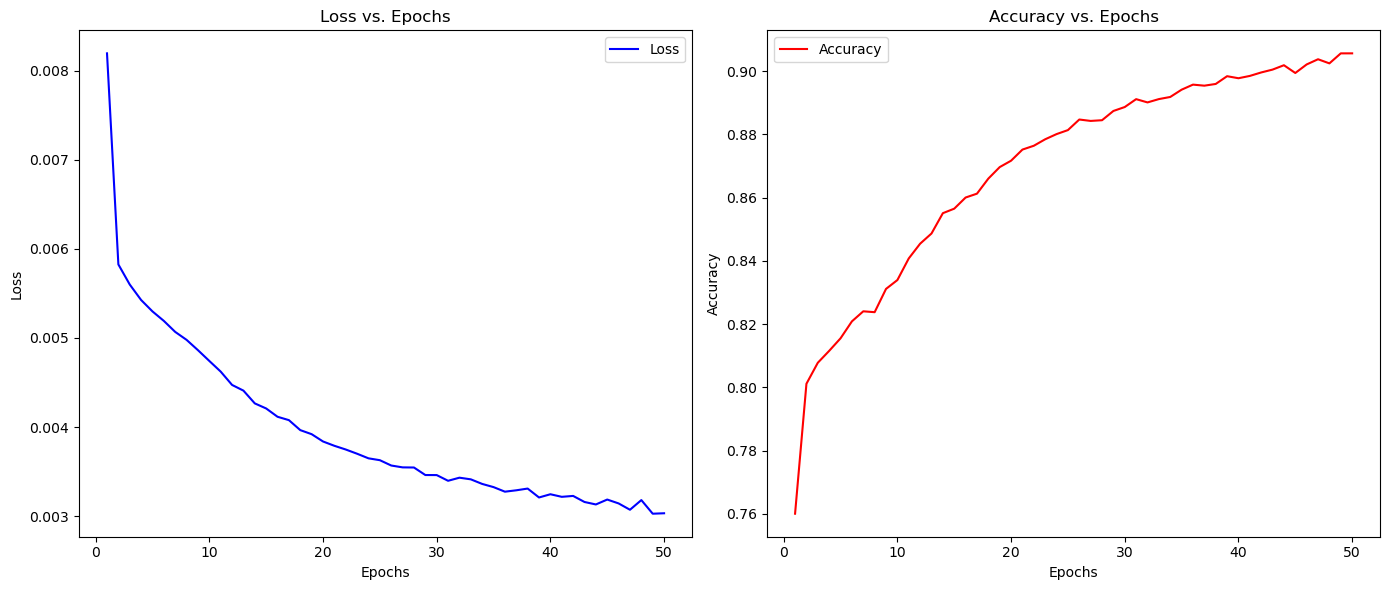

In [7]:
# Plot loss and accuracy vs. epochs
epochs = range(1, len(losses) + 1)

plt.figure(figsize=(14, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, losses, 'b-', label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracies, 'r-', label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
plt.legend()

plt.tight_layout()
plt.savefig("bdtplots/dnn/loss_accuracy_vs_epochs.png")
plt.savefig("bdtplots/dnn/loss_accuracy_vs_epochs.pdf")
plt.show()

In [8]:
# Define a function to get predictions from the PyTorch model
def get_predictions(loader, model):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in loader:
            X_batch, y_batch, _ = batch
            outputs = model(X_batch)
            predicted = outputs.squeeze().cpu().numpy()
            all_preds.extend(predicted)
            all_labels.extend(y_batch.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

In [9]:
def evaluate_model(model, test_loader, criterion):
    model.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for inputs, labels, weights in test_loader:
            outputs = model(inputs)
            outputs = outputs.squeeze()
            y_true.extend(labels.tolist())
            y_pred.extend(outputs.tolist())
    
    y_pred_binary = [1 if x > 0.5 else 0 for x in y_pred]
    accuracy = accuracy_score(y_true, y_pred_binary)
    roc_auc = roc_auc_score(y_true, y_pred)
    
    print(f"Accuracy: {accuracy:.4f}, ROC AUC: {roc_auc:.4f}")
    print(classification_report(y_true, y_pred_binary))
    
    return y_true, y_pred  # Return both y_true and y_pred


Accuracy: 0.8877, ROC AUC: 0.9912
              precision    recall  f1-score   support

           0       0.79      1.00      0.88     19727
           1       1.00      0.81      0.89     26395

    accuracy                           0.89     46122
   macro avg       0.90      0.90      0.89     46122
weighted avg       0.91      0.89      0.89     46122

Weighted ROC AUC on test set: 0.9912594879218524
              precision    recall  f1-score   support

           0       0.79      1.00      0.88     19727
           1       1.00      0.81      0.89     26395

    accuracy                           0.89     46122
   macro avg       0.90      0.90      0.89     46122
weighted avg       0.91      0.89      0.89     46122



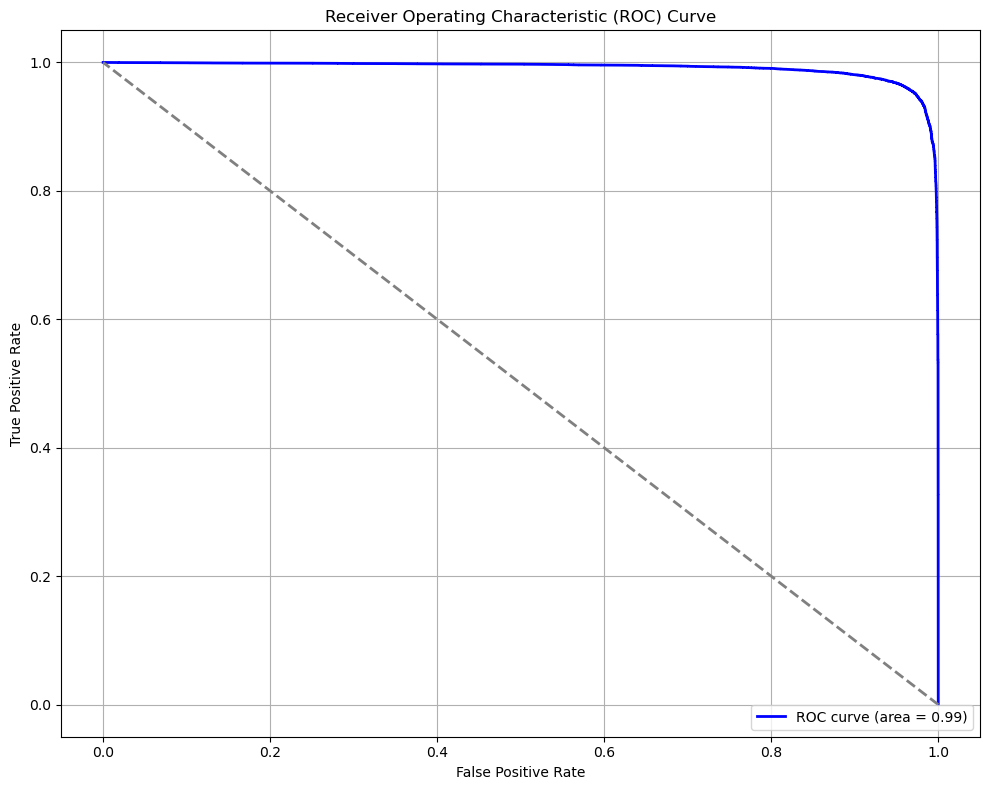

In [10]:
# Evaluate the model
y_test_true, y_test_pred = evaluate_model(model, test_loader, criterion)

# Calculate ROC AUC
roc_auc = roc_auc_score(y_test_true, y_test_pred, sample_weight=X_test_weights_tensor)

print("Weighted ROC AUC on test set:", roc_auc)
print(classification_report(y_test_true, [1 if x > 0.5 else 0 for x in y_test_pred]))

# Optionally, plot weighted ROC curve
fpr, tpr, thresholds = roc_curve(y_test_true, y_test_pred, sample_weight=X_test_weights_tensor)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(1-fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([1, 0], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.savefig("bdtplots/dnn/srbbgg_roc-curve.png")
plt.savefig("bdtplots/dnn/srbbgg_roc-curve.pdf")
plt.tight_layout()
plt.show()

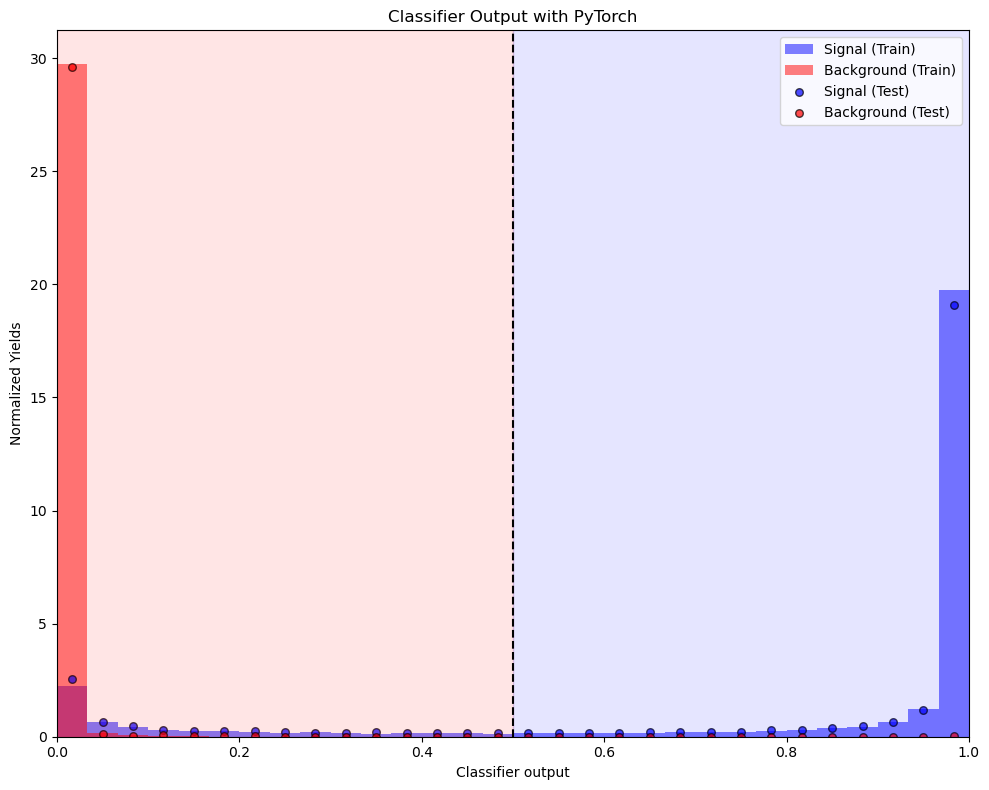

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Define a function to get predictions from the PyTorch model
def get_predictions(loader, model):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels, _ in loader:
            outputs = model(inputs)
            outputs = outputs.squeeze()
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

# Get predictions for training and test data
train_preds, train_true = get_predictions(train_loader, model)
test_preds, test_true = get_predictions(test_loader, model)

# Convert weights tensors to NumPy arrays
X_train_weights_np = X_train_weights_tensor.numpy()
X_test_weights_np = X_test_weights_tensor.numpy()

# Define bins
bins = np.linspace(0, 1, 31)  

# Calculate histograms and bins for training data with weights
train_hist_s, _ = np.histogram(train_preds[train_true == 1], bins=bins, density=True, weights=X_train_weights_np[train_true == 1])
train_hist_b, _ = np.histogram(train_preds[train_true == 0], bins=bins, density=True, weights=X_train_weights_np[train_true == 0])

# Calculate bin centers
bin_centers = (bins[:-1] + bins[1:]) / 2

# Plot histograms for training data
plt.figure(figsize=(10, 8))
plt.hist(train_preds[train_true == 1], bins=bins, color='blue', alpha=0.5, label='Signal (Train)', density=True, weights=X_train_weights_np[train_true == 1])
plt.hist(train_preds[train_true == 0], bins=bins, color='red', alpha=0.5, label='Background (Train)', density=True, weights=X_train_weights_np[train_true == 0])

# Calculate histograms for test data
test_hist_s, _ = np.histogram(test_preds[test_true == 1], bins=bins, density=True, weights=X_test_weights_np[test_true == 1])
test_hist_b, _ = np.histogram(test_preds[test_true == 0], bins=bins, density=True, weights=X_test_weights_np[test_true == 0])

# Plot scatter points for test data
plt.scatter(bin_centers, test_hist_s, color='blue', alpha=0.7, label='Signal (Test)', marker='o', s=30, edgecolor='k')
plt.scatter(bin_centers, test_hist_b, color='red', alpha=0.7, label='Background (Test)', marker='o', s=30, edgecolor='k')


# Add background colors
plt.axvspan(0, 0.5, color='red', alpha=0.1)
plt.axvspan(0.5, 1, color='blue', alpha=0.1)

plt.axvline(0.5, color='k', linestyle='--')
plt.xlabel('Classifier output')
plt.ylabel('Normalized Yields')
plt.xlim(0,1)
plt.legend()
plt.title('Classifier Output with PyTorch')

# Save and display the plotpurple
plt.savefig("bdtplots/dnn/classifier_output_plot.png")
plt.savefig("bdtplots/dnn/classifier_output_plot.pdf")
plt.tight_layout()
plt.show()


In [12]:
## BDT

In [13]:
from sklearn.ensemble import GradientBoostingClassifier


In [14]:
# Convert data to numpy arrays
def extract_data_from_loader(loader):
    inputs_list = []
    labels_list = []
    for inputs, labels, _ in loader:
        inputs_list.append(inputs.numpy())
        labels_list.append(labels.numpy())
    return np.vstack(inputs_list), np.concatenate(labels_list)


In [ ]:
X_train_numpy, y_train_numpy = extract_data_from_loader(train_loader)
X_test_numpy, y_test_true = extract_data_from_loader(test_loader)

# Train a Gradient Boosting Classifier
bdt_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.01, max_depth=100, loss='exponential')
bdt_model.fit(X_train_numpy, y_train_numpy)


In [16]:
y_test_pred_bdt = bdt_model.predict_proba(X_test_numpy)[:, 1]


In [17]:
roc_auc_bdt = roc_auc_score(y_test_true, y_test_pred_bdt)


In [18]:
print("ROC AUC for BDT on test set:", roc_auc_bdt)
print(classification_report(y_test_true, [1 if x > 0.5 else 0 for x in y_test_pred_bdt]))


ROC AUC for BDT on test set: 0.9399514713209816
              precision    recall  f1-score   support

           0       0.91      0.90      0.91     19727
           1       0.93      0.94      0.93     26395

    accuracy                           0.92     46122
   macro avg       0.92      0.92      0.92     46122
weighted avg       0.92      0.92      0.92     46122



In [19]:
X_train_numpy, y_train_numpy = extract_data_from_loader(train_loader)
X_test_numpy, y_test_true = extract_data_from_loader(test_loader)


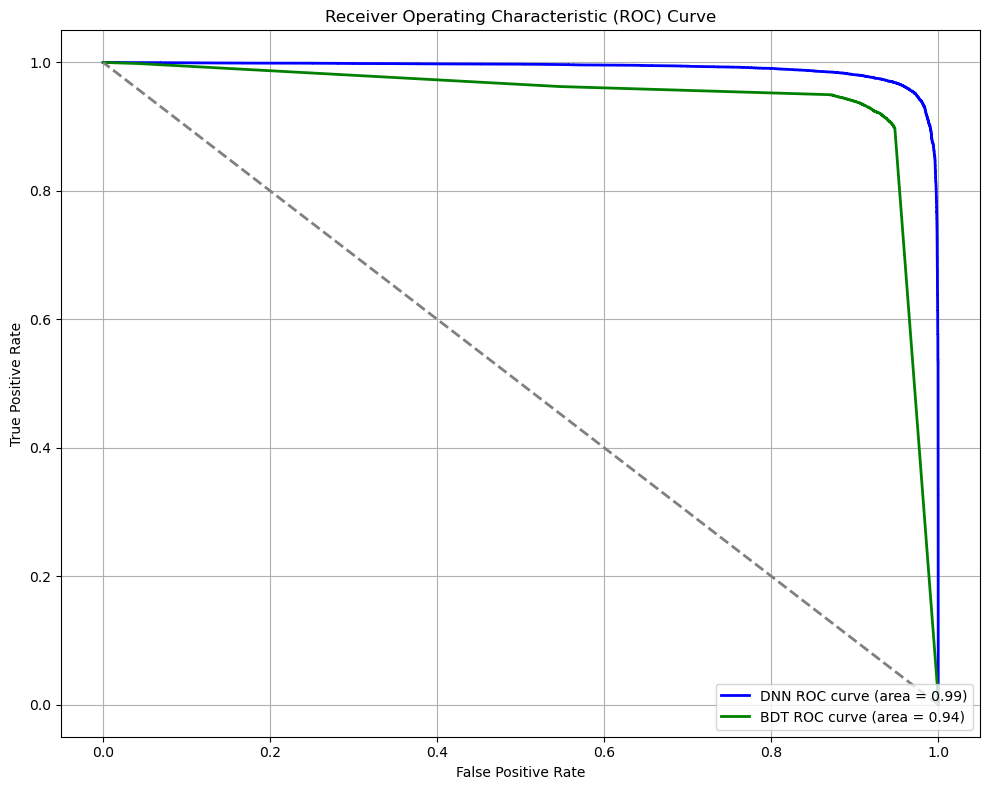

In [20]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Ensure y_test_true, y_test_pred, y_test_pred_bdt, X_train_weights_np, and X_test_weights_numpy are defined and correct
# Plot ROC curves
fpr_dnn, tpr_dnn, _ = roc_curve(y_test_true, y_test_pred, sample_weight=X_test_weights_np)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)

fpr_bdt, tpr_bdt, _ = roc_curve(y_test_true, y_test_pred_bdt, sample_weight=X_test_weights_np)
roc_auc_bdt = auc(fpr_bdt, tpr_bdt)

plt.figure(figsize=(10, 8))
plt.plot(1-fpr_dnn, tpr_dnn, color='blue', lw=2, label=f'DNN ROC curve (area = {roc_auc_dnn:.2f})')
plt.plot(1-fpr_bdt, tpr_bdt, color='green', lw=2, label=f'BDT ROC curve (area = {roc_auc_bdt:.2f})')
plt.plot([1,0], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.savefig("bdtplots/dnn/roc_comparison.png")
plt.savefig("bdtplots/dnn/roc_comparison.pdf")
plt.tight_layout()
plt.show()


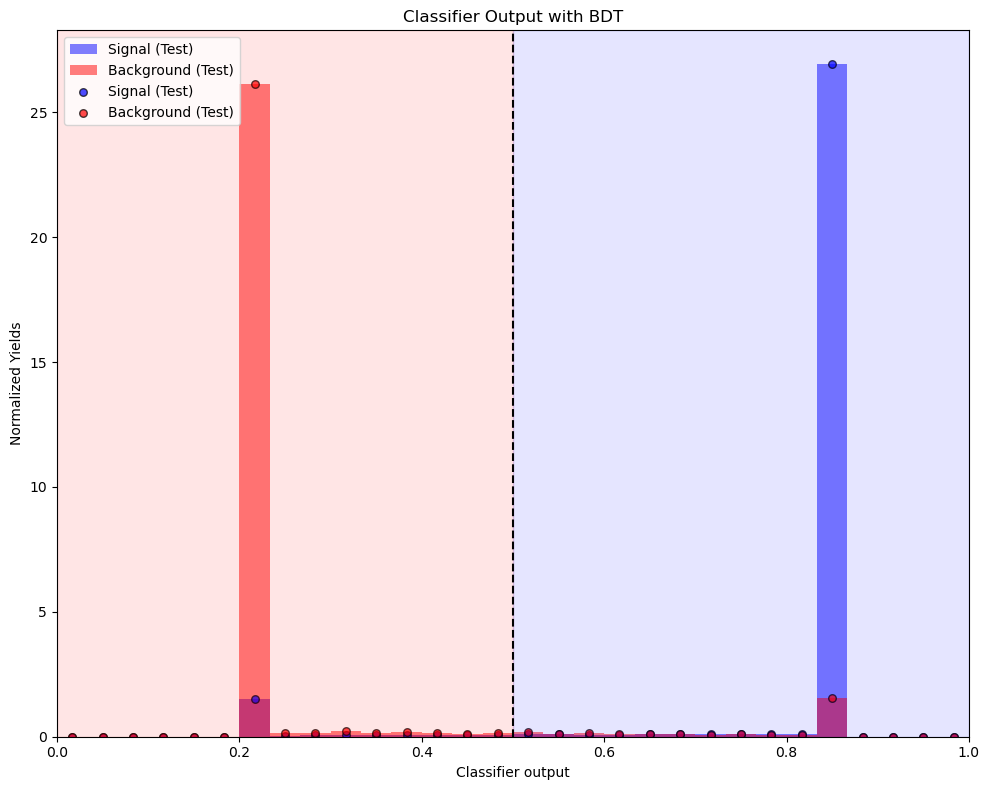

In [37]:
# Convert weights tensors to NumPy arrays
X_train_weights_np = X_train_weights_tensor.numpy()
X_test_weights_np = X_test_weights_tensor.numpy()

# Define bins
bins = np.linspace(0, 1, 31)

# Calculate histograms and bins for test data with weights
test_hist_s, _ = np.histogram(y_test_pred_bdt[y_test_true == 1], bins=bins, density=True, weights=X_test_weights_np[y_test_true == 1])
test_hist_b, _ = np.histogram(y_test_pred_bdt[y_test_true == 0], bins=bins, density=True, weights=X_test_weights_np[y_test_true == 0])

# Calculate bin centers
bin_centers = (bins[:-1] + bins[1:]) / 2

# Plot histograms for test data
plt.figure(figsize=(10, 8))
plt.hist(y_test_pred_bdt[y_test_true == 1], bins=bins, color='blue', alpha=0.5, label='Signal (Test)', density=True, weights=X_test_weights_np[y_test_true == 1])
plt.hist(y_test_pred_bdt[y_test_true == 0], bins=bins, color='red', alpha=0.5, label='Background (Test)', density=True, weights=X_test_weights_np[y_test_true == 0])

# Plot scatter points for test data
plt.scatter(bin_centers, test_hist_s, color='blue', alpha=0.7, label='Signal (Test)', marker='o', s=30, edgecolor='k')
plt.scatter(bin_centers, test_hist_b, color='red', alpha=0.7, label='Background (Test)', marker='o', s=30, edgecolor='k')

# Add background colors
plt.axvspan(0, 0.5, color='red', alpha=0.1)
plt.axvspan(0.5, 1, color='blue', alpha=0.1)

plt.axvline(0.5, color='k', linestyle='--')
plt.xlabel('Classifier output')
plt.ylabel('Normalized Yields')
plt.xlim(0,1)
plt.legend()
plt.title('Classifier Output with BDT')

# Save and display the plot
# plt.savefig("bdtplots/bdt/classifier_output_plot.png")
# plt.savefig("bdtplots/bdt/classifier_output_plot.pdf")
plt.tight_layout()
plt.show()

In [21]:
## XGBoost

In [22]:
import xgboost as xgb


In [23]:
# Ensure all weights are positive
X_train_weights_np = np.maximum(X_train_weights_np, 1e-6)

# Train XGBoost model
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train_numpy, y_train_numpy, sample_weight=X_train_weights_np)
y_test_pred_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Plot ROC curve for XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_test_pred_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)



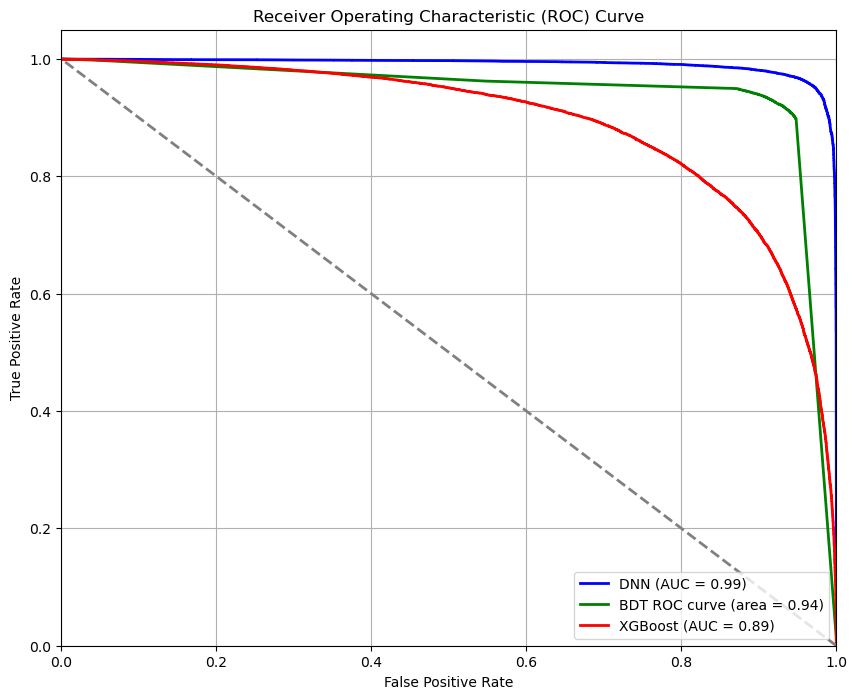

In [24]:
# Plot ROC curve for both models
plt.figure(figsize=(10, 8))
plt.plot(1-fpr, tpr, color='blue', lw=2, label='DNN (AUC = %0.2f)' % roc_auc)
plt.plot(1-fpr_bdt, tpr_bdt, color='green', lw=2, label=f'BDT ROC curve (area = {roc_auc_bdt:.2f})')
plt.plot(1-fpr_xgb, tpr_xgb, color='red', lw=2, label='XGBoost (AUC = %0.2f)' % roc_auc_xgb)
plt.plot([1, 0], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

# MLP

In [25]:
from sklearn.neural_network import MLPClassifier


In [26]:
?MLPClassifier

Init signature:
MLPClassifier(
    hidden_layer_sizes=(100,),
    activation='relu',
    *,
    solver='adam',
    alpha=0.0001,
    batch_size='auto',
    learning_rate='constant',
    learning_rate_init=0.001,
    power_t=0.5,
    max_iter=200,
    shuffle=True,
    random_state=None,
    tol=0.0001,
    verbose=False,
    warm_start=False,
    momentum=0.9,
    nesterovs_momentum=True,
    early_stopping=False,
    validation_fraction=0.1,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-08,
    n_iter_no_change=10,
    max_fun=15000,
)
Docstring:     
Multi-layer Perceptron classifier.

This model optimizes the log-loss function using LBFGS or stochastic
gradient descent.

.. versionadded:: 0.18

Parameters
----------
hidden_layer_sizes : array-like of shape(n_layers - 2,), default=(100,)
    The ith element represents the number of neurons in the ith
    hidden layer.

activation : {'identity', 'logistic', 'tanh', 'relu'}, default='relu'
    Activation function for the hidden laye

In [27]:
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, alpha=0.001, solver='adam', random_state=42)
mlp_model.fit(X_train_numpy, y_train_numpy)


MLPClassifier(alpha=0.001, max_iter=500, random_state=42)

In [28]:
y_test_pred_mlp = mlp_model.predict_proba(X_test)[:, 1]
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, y_test_pred_mlp)
roc_auc_mlp = auc(fpr_mlp, tpr_mlp)


/home/shivam-raj/miniforge3/envs/hhbbgg-awk/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


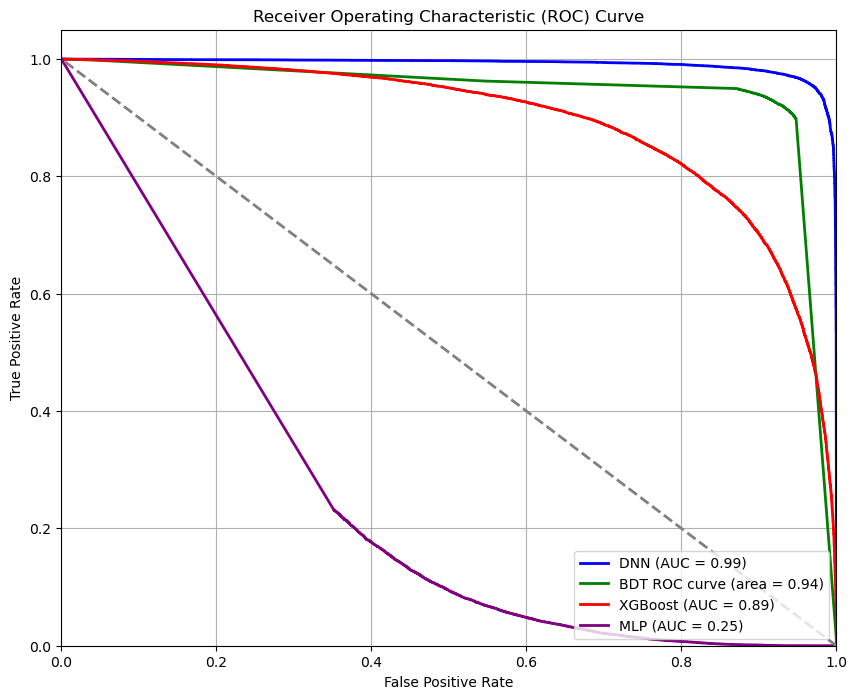

In [29]:
plt.figure(figsize=(10, 8))
plt.plot(1-fpr, tpr, color='blue', lw=2, label='DNN (AUC = %0.2f)' % roc_auc)
plt.plot(1-fpr_bdt, tpr_bdt, color='green', lw=2, label=f'BDT ROC curve (area = {roc_auc_bdt:.2f})')
plt.plot(1-fpr_xgb, tpr_xgb, color='red', lw=2, label='XGBoost (AUC = %0.2f)' % roc_auc_xgb)
plt.plot(1-fpr_mlp, tpr_mlp, color='purple', lw=2, label='MLP (AUC = %0.2f)' % roc_auc_mlp)
plt.plot([1, 0], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [30]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Parameters
input_size = X_train_tensor.shape[1]
hidden_size = 100
num_classes = 2
num_epochs = 50
learning_rate = 0.001

# Initialize the model, loss function, and optimizer
model = MLP(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [31]:
# Training loop
model.train()
for epoch in range(num_epochs):
    for inputs, labels, weights in train_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [10/50], Loss: 0.0161
Epoch [20/50], Loss: 0.0097
Epoch [30/50], Loss: 0.0323
Epoch [40/50], Loss: 0.0264
Epoch [50/50], Loss: 0.0178


In [32]:
# Evaluate the model
model.eval()
y_test_pred_mlp = []
with torch.no_grad():
    for inputs, labels, weights in test_loader:
        outputs = model(inputs)
        probabilities = nn.functional.softmax(outputs, dim=1)[:, 1]
        y_test_pred_mlp.extend(probabilities.numpy())

# Convert to numpy array
y_test_pred_mlp = np.array(y_test_pred_mlp)

# Compute ROC curve and AUC
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, y_test_pred_mlp)
roc_auc_mlp = auc(fpr_mlp, tpr_mlp)


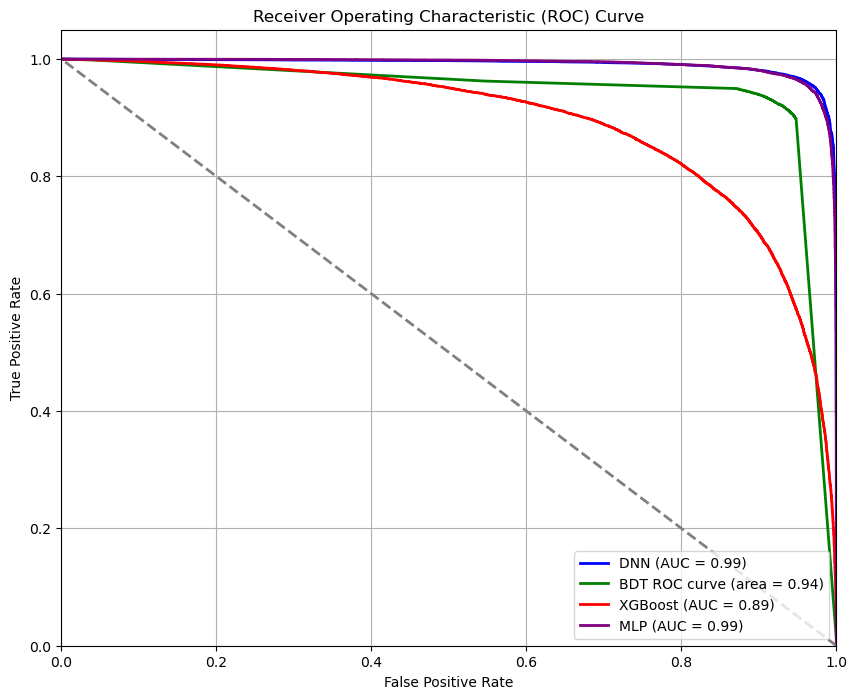

In [33]:
# Plot ROC curves
plt.figure(figsize=(10, 8))
plt.plot(1 - fpr, tpr, color='blue', lw=2, label=f'DNN (AUC = {roc_auc:.2f})')
plt.plot(1 - fpr_bdt, tpr_bdt, color='green', lw=2, label=f'BDT ROC curve (area = {roc_auc_bdt:.2f})')
plt.plot(1 - fpr_xgb, tpr_xgb, color='red', lw=2, label=f'XGBoost (AUC = {roc_auc_xgb:.2f})')
plt.plot(1 - fpr_mlp, tpr_mlp, color='purple', lw=2, label=f'MLP (AUC = {roc_auc_mlp:.2f})')
plt.plot([1, 0], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.savefig("ROC_Curve.png")
plt.savefig("ROC_Curve.pdf")
plt.show()
